In [ ]:
import jax

jax.config.update("jax_enable_x64", True)
import warnings

import jax.numpy as jnp

warnings.filterwarnings("ignore", module="erfa")

import astropy.units as u
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib.lines import Line2D
from tqdm import tqdm

from jorbit import Particle
from jorbit.utils.horizons import horizons_bulk_astrometry_query

In [2]:
np.random.seed(42)
particle_ids = np.random.randint(0, 700_000, size=100)

times = Time("2025-01-01") + jnp.arange(0, 365 * 10, 10) * u.day

seps = np.zeros((len(particle_ids), len(times)))
for i, p_id in tqdm(enumerate(particle_ids)):
    p = Particle.from_horizons(name=str(p_id), time=Time("2025-01-01"))
    jorbit_eph = p.ephemeris(times=times, observer="kitt peak")

    data = horizons_bulk_astrometry_query(
        target=str(p_id), center="695@399", times=times
    )
    horizons_eph = SkyCoord(
        ra=data["RA"], dec=data["DEC"], unit=(u.deg, u.deg), obstime=times
    )
    separation = jorbit_eph.separation(horizons_eph)
    seps[i] = separation.to(u.mas).value

np.save("data/horizons_vs_jorbit.npy", seps)

100it [22:47, 13.68s/it]


In [19]:
np.random.seed(42)
particle_ids = np.random.randint(0, 700_000, size=100)

times = Time("2025-01-01") + jnp.arange(0, 365 * 10, 10) * u.day

observatory_seps = np.zeros((len(particle_ids), len(times)))
for i, p_id in tqdm(enumerate(particle_ids)):
    data1 = horizons_bulk_astrometry_query(
        target=str(p_id), center="695@399", times=times
    )
    horizons_eph1 = SkyCoord(
        ra=data1["RA"], dec=data1["DEC"], unit=(u.deg, u.deg), obstime=times
    )

    data2 = horizons_bulk_astrometry_query(
        target=str(p_id), center="675@399", times=times
    )
    horizons_eph2 = SkyCoord(
        ra=data2["RA"], dec=data2["DEC"], unit=(u.deg, u.deg), obstime=times
    )

    separation = horizons_eph1.separation(horizons_eph2)
    observatory_seps[i] = separation.to(u.mas).value

np.save("data/difference_between_observatories.npy", observatory_seps)

100it [07:32,  4.52s/it]


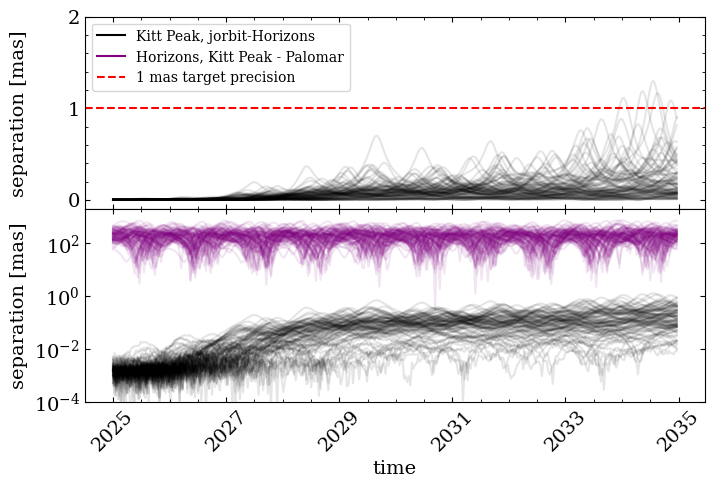

In [64]:
seps = np.load("data/horizons_vs_jorbit.npy")
observatory_seps = np.load("data/difference_between_observatories.npy")

fig, ax = plt.subplots(figsize=(8, 5), nrows=2, sharex=True)
line1 = ax[0].plot(
    times.datetime,
    seps.T[:, 0],
    alpha=0.1,
    color="k",
    label="Kitt Peak, jorbit-Horizons",
)
line2 = ax[0].plot(
    times.datetime,
    observatory_seps[:1:].T,
    alpha=0.1,
    color="purple",
    label="Horizons, Kitt Peak - Palomar",
)
ax[0].plot(times.datetime, seps.T[:, 1:], alpha=0.1, color="k")
line3 = ax[0].axhline(1.0, ls="--", color="r", label="1 mas target precision")
ax[0].set(ylabel="separation [mas]", ylim=(-0.1, 2.0))

handles, labels = ax[0].get_legend_handles_labels()
legend_line1 = Line2D(
    [0],
    [0],
    color=line1[0].get_color(),
    linestyle=line1[0].get_linestyle(),
    linewidth=line1[0].get_linewidth(),
    marker=line1[0].get_marker(),
    alpha=1.0,
)
legend_line2 = Line2D(
    [0],
    [0],
    color=line2[0].get_color(),
    linestyle=line2[0].get_linestyle(),
    linewidth=line2[0].get_linewidth(),
    marker=line2[0].get_marker(),
    alpha=1.0,
)
ax[0].legend([legend_line1, legend_line2, line3], labels, fontsize=10)

ax[1].plot(times.datetime, observatory_seps.T, alpha=0.1, color="purple")
ax[1].plot(times.datetime, seps.T, alpha=0.1, color="k")
ax[1].set(
    yscale="log",
    xlabel="time",
    ylabel="separation [mas]",
    ylim=(1e-4, 2e3),
    xticks=(Time("2025-01-01") + np.arange(0, 10.01, 2) * u.year).datetime,
)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

plt.subplots_adjust(hspace=0)
fig.align_ylabels()
plt.savefig("figures/horizons_skypos_agreement.pdf", bbox_inches="tight")

In [24]:
times[-1], np.median(observatory_seps[:, -1]), np.median(seps[:, -1])

(<Time object: scale='utc' format='iso' value=2034-12-20 00:00:00.000>,
 np.float64(209.35497059374984),
 np.float64(0.12996721405660033))